In [1]:
import numpy as np
import pycbc
import gwpy
import matplotlib.pyplot as plt

from numpy import random
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

/home/vboxuser/miniforge3/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
# get Hanford data
H1_1data = TimeSeries.read('H1_TEST1.hdf')
print(H1_1data.crop(0, 10))
hasd1 = H1_1data.asd(fftlength=4, method="median")

TimeSeries([2.53567919e-21, 1.18872265e-20, 2.72576599e-21, ...,
            3.59246579e-20, 5.00180678e-20, 3.83926840e-20]
           unit: dimensionless,
           t0: 0.0 s,
           dt: 0.00048828125 s,
           name: Strain,
           channel: H1:FAKE_2048)


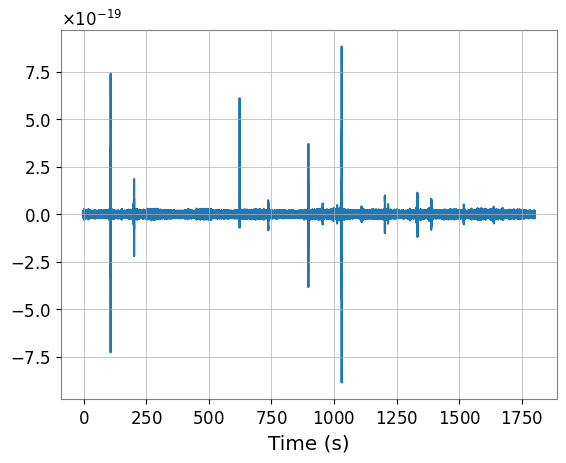

In [3]:
import pylab
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.types import TimeSeries as PyCBC_TimeSeries

# Use the existing H1_1data variable
hstrain1 = H1_1data.to_pycbc()  # Convert to pycbc TimeSeries

# Remove the low frequency content and downsample the data to 2048Hz
hstrain1 = highpass(hstrain1, 15.0)
hstrain1 = resample_to_delta_t(hstrain1, 1.0/2048)

pylab.plot(hstrain1.sample_times, hstrain1)
pylab.xlabel('Time (s)')
pylab.show()

[   2.            2.00048828    2.00097656 ... 1797.99853516
 1797.99902344 1797.99951172]


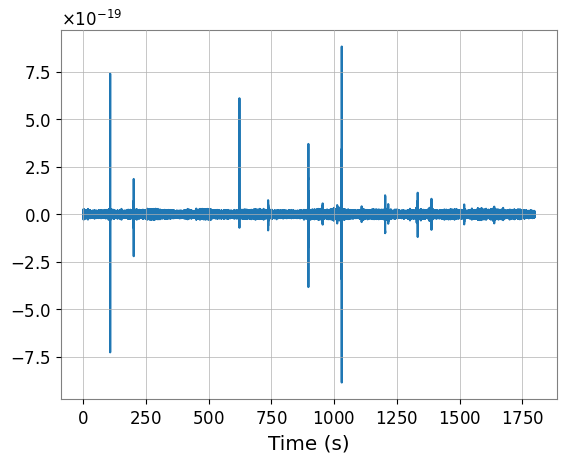

In [4]:
# Remove 2 seconds of data from both the beginning and end
hconditioned1 = hstrain1.crop(2, 2)

print(hconditioned1.sample_times)

pylab.plot(hconditioned1.sample_times, hconditioned1)
pylab.xlabel('Time (s)')
pylab.show()

In [5]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
hpsd1 = hconditioned1.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
hpsd1 = interpolate(hpsd1, hconditioned1.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
hpsd1 = inverse_spectrum_truncation(hpsd1, int(4 * hconditioned1.sample_rate),
                                  low_frequency_cutoff=15)


In [6]:
from pycbc.waveform import get_td_waveform

m = 10 # Solar masses
hp_H1, hc_H1 = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=hconditioned1.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp_H1.resize(len(hconditioned1))

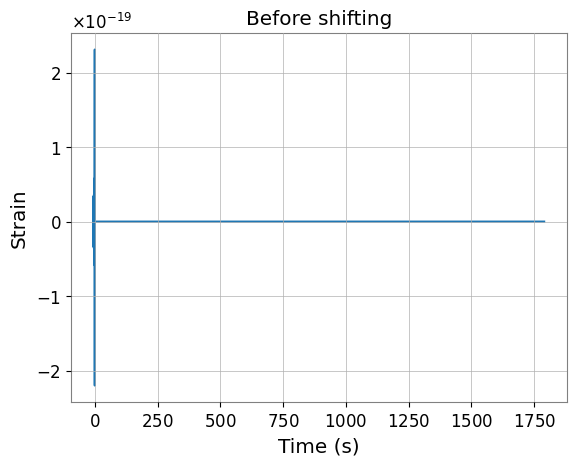

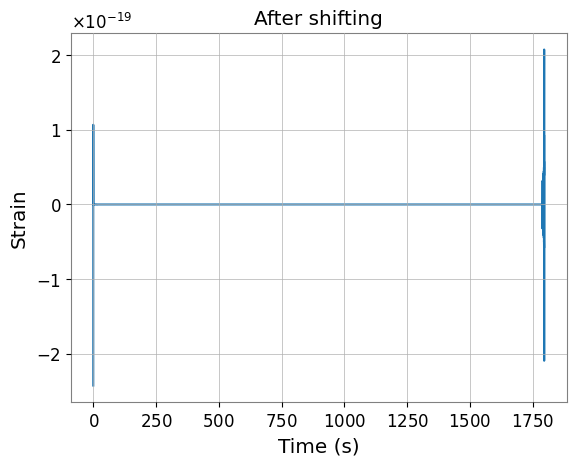

In [7]:
# Let's plot the signal before and after shifting

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp_H1.sample_times, hp_H1)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template_H1 = hp_H1.cyclic_time_shift(hp_H1.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template_H1.sample_times, template_H1)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.show()

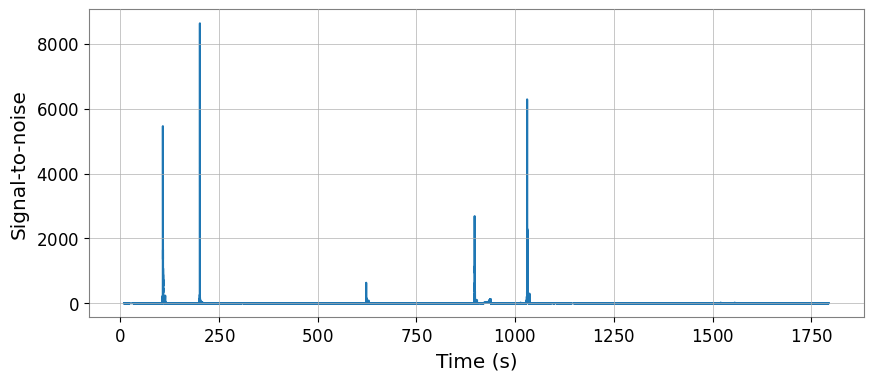

We found a signal at 201.9755859375s with SNR 8628.598260738316


In [8]:
from pycbc.filter import matched_filter
import numpy

snr_H1 = matched_filter(template_H1, hconditioned1,
                     psd=hpsd1, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seconds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr_H1 = snr_H1.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion corresponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr_H1.sample_times, abs(snr_H1))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr_H1).numpy().argmax()
snrp = snr_H1[peak]
time = snr_H1.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

In [9]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - hconditioned1.start_time
aligned = template_H1.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=hpsd1, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = hconditioned1.start_time

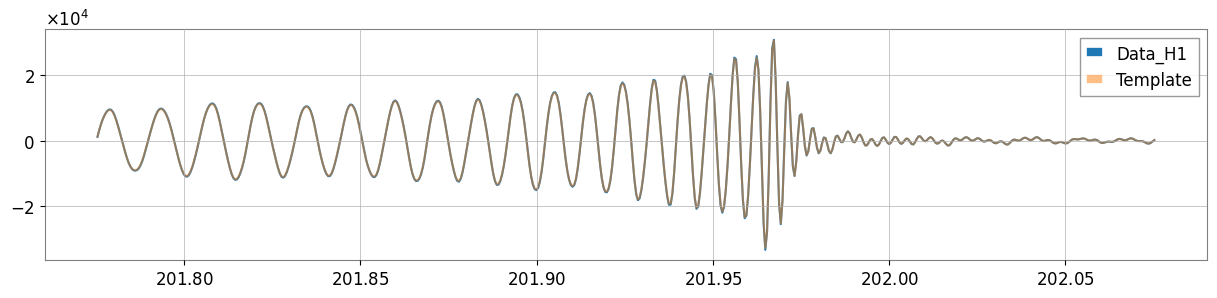

In [10]:
# We do it this way so that we can whiten both the template and the data
white_data = (hconditioned1.to_frequencyseries() / hpsd1**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / hpsd1**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)
merger_time_H1 = 201.9755859375
# Select the time around the merger
white_data_s = white_data.time_slice(merger_time_H1-.2, merger_time_H1+.1)
white_template_s = white_template.time_slice(merger_time_H1-.2, merger_time_H1+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data_s.sample_times, white_data_s, label="Data_H1")
pylab.plot(white_template_s.sample_times, white_template_s, label="Template", alpha=0.5)
pylab.legend()
pylab.show()

In [14]:
# hconditioned1_d = hconditioned1.time_slice(merger_time_H1 - 2, merger_time_H1 + 1)
# print(hconditioned1,hconditioned1_d)
# aligned_d = aligned.time_slice(merger_time_H1 - 2, merger_time_H1 + 1)

# subtracted_d = hconditioned1_d - aligned_d
# print(hconditioned1.shape,subtracted_d.shape)

# subtracted = hconditioned1 - aligned

# Plot the original data and the subtracted signal data

# for data, title in [(hconditioned1_d, 'Original H1 Data'),
#                     (subtracted_d, 'Signal Subtracted from H1 Data')]:

#     t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))
#     pylab.figure(figsize=[15, 3])
#     pylab.title(title)
#     pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
#     pylab.yscale('log')
#     pylab.xlabel('Time (s)')
#     pylab.ylabel('Frequency (Hz)')
#     pylab.xlim(merger_time_H1 - 2, merger_time_H1 + 1)
#     pylab.show()

data = white_data.time_slice(merger_time_H1 - 2, merger_time_H1 + 1).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 1024))
print(data)

title = 'Original H1 Data'

# t, f, p = data.whiten(4, 4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 1024))

t = data.sample_times
f = data.sample_frequencies
p = hpsd1

pylab.figure(figsize=[15, 3])
pylab.title(title)
pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6, shading='auto')
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.xlim(merger_time_H1 - 2, merger_time_H1 + 1)
pylab.show()

ValueError: operands could not be broadcast together with shapes (1764,) (1853,) 